In [1]:
# pip install
!pip install -r requirements.txt

# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use(['science','no-latex'])
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from pprint import pprint
import time

# Module imports
from periodic_table import *
from utils import *
print("Imported all.")
DPI = 800

Imported all.


# Open data files

In [2]:
# original, NC, FTFP
physic_model = "FTFP_5cm"

# Open propmt TPC data file
file_dir = f"./assets/{physic_model}/A_Z_count-TPC_prompt.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_TPC_prompt = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_TPC_prompt)
# Reorder columns
df_TPC_prompt = df_TPC_prompt[["Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life (s)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

Considered delayed if created at time > 20 microseconds

In [3]:
# Open delayed TPC data file
file_dir = f"./assets/{physic_model}/A_Z_count-TPC_delayed.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_TPC_delayed = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_TPC_delayed)
# Reorder columns
df_TPC_delayed = df_TPC_delayed[["Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life (s)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

In [4]:
# Open buffer data file
file_dir = f"./assets/{physic_model}/A_Z_count-buffers.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_buffers = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_buffers)
# Reorder columns
df_buffers = df_buffers[["Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life (s)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

# Preprocessing

### Add Production (/yr)

In [5]:
# Simulation length = years * nanoseconds
year_in_nano = (3.154 * 10**16)
year_in_sec = (3.154 * 10**7)
day_in_sec = 86400
### VARY THIS ###
muon_no = 10 ** 8
muon_flux = 3.447 * 10 ** 6 # per year
sim_length = muon_no / muon_flux
print(f"Simulation length (yr): {sim_length}")

df_buffers["Production (/yr)"] = df_buffers["Counts"] / sim_length
df_TPC_prompt["Production (/yr)"] = df_TPC_prompt["Counts"] / sim_length
df_TPC_delayed["Production (/yr)"] = df_TPC_delayed["Counts"] / sim_length
# Yield per muon
df_buffers["Yield per Muon (/yr)"] = df_buffers["Counts"] / muon_no
df_TPC_prompt["Yield per Muon (/yr)"] = df_TPC_prompt["Counts"] / muon_no
df_TPC_delayed["Yield per Muon (/yr)"] = df_TPC_delayed["Counts"] / muon_no

Simulation length (yr): 29.01073397156948


### Create unstable dfs

In [6]:
unstable_buffers = df_buffers[df_buffers["Stable"] == False]
unstable_TPC_prompt = df_TPC_prompt[df_TPC_prompt["Stable"] == False]
unstable_TPC_delayed = df_TPC_delayed[df_TPC_delayed["Stable"] == False]

### Print Information

In [7]:
print("Buffers:")
print(f"No: {len(df_buffers)}")
print(f"Total Counts: {df_buffers['Counts'].sum()}")
print(f"Total Production (yr): {df_buffers['Production (/yr)'].sum()}")
print(f"Number of stable isotopes: {len(df_buffers) - len(unstable_buffers)}")
print(f"Number of unstable isotopes: {len(unstable_buffers)}")
print()
print("TPC Prompt:")
print(f"No: {len(df_TPC_prompt)}")
print(f"Total Counts: {df_TPC_prompt['Counts'].sum()}")
print(f"Total Production (yr): {df_TPC_prompt['Production (/yr)'].sum()}")
print(f"Number of stable isotopes: {len(df_TPC_prompt) - len(unstable_TPC_prompt)}")
print(f"Number of unstable isotopes: {len(unstable_TPC_prompt)}")
print()
print("TPC Delayed:")
print(f"No: {len(df_TPC_delayed)}")
print(f"Total Counts: {df_TPC_delayed['Counts'].sum()}")
print(f"Total Production (yr): {df_TPC_delayed['Production (/yr)'].sum()}")
print(f"Number of stable isotopes: {len(df_TPC_delayed) - len(unstable_TPC_delayed)}")
print(f"Number of unstable isotopes: {len(unstable_TPC_delayed)}")

Buffers:
No: 179
Total Counts: 188984785
Total Production (yr): 6514305.53895
Number of stable isotopes: 41
Number of unstable isotopes: 138

TPC Prompt:
No: 171
Total Counts: 79791652
Total Production (yr): 2750418.2444399996
Number of stable isotopes: 40
Number of unstable isotopes: 131

TPC Delayed:
No: 91
Total Counts: 17935306
Total Production (yr): 618229.9978199999
Number of stable isotopes: 38
Number of unstable isotopes: 53


### Filter by realistic half-life

Find max and min half lifes

In [8]:
print("Buffers:")
print(f"Min half life (sec): {unstable_buffers['Half Life (s)'].min()}\nMax half life (day): {unstable_buffers['Half Life (s)'].max() / day_in_sec}")
print("TPC Prompt:")
print(f"Min half life (sec): {unstable_TPC_prompt['Half Life (s)'].min()}\nMax half life (day): {unstable_TPC_prompt['Half Life (s)'].max() / day_in_sec}")
print("TPC Delayed:")
print(f"Min half life (sec): {unstable_TPC_delayed['Half Life (s)'].min()}\nMax half life (day): {unstable_TPC_delayed['Half Life (s)'].max() / day_in_sec}")

Buffers:
Min half life (sec): 0.0
Max half life (day): 1.0960648148148148e+24
TPC Prompt:
Min half life (sec): 0.0
Max half life (day): 1.0960648148148148e+24
TPC Delayed:
Min half life (sec): 7.91e-22
Max half life (day): 1.0960648148148148e+24


In [9]:
# year * days * seconds
upper_lim = 1 * 356 * day_in_sec
print(f"Removing isotopes with decay time longer than: {upper_lim}s")
unstable_buffers_rem = unstable_buffers[unstable_buffers["Half Life (s)"] > upper_lim].sort_values("Half Life (s)")
unstable_TPC_prompt_rem = unstable_TPC_prompt[unstable_TPC_prompt["Half Life (s)"] > upper_lim].sort_values("Half Life (s)")
unstable_TPC_delayed_rem = unstable_TPC_delayed[unstable_TPC_delayed["Half Life (s)"] > upper_lim].sort_values("Half Life (s)")
#print("Removed isotopes:")
#print(unstable_buffers_rem)
#print(unstable_TPC_prompt_rem)
#print(unstable_TPC_delayed_rem)

Removing isotopes with decay time longer than: 30758400s


In [10]:
unstable_buffers = unstable_buffers[unstable_buffers["Half Life (s)"] < upper_lim].sort_values("Half Life (s)")
unstable_TPC_prompt = unstable_TPC_prompt[unstable_TPC_prompt["Half Life (s)"] < upper_lim].sort_values("Half Life (s)")
unstable_TPC_delayed = unstable_TPC_delayed[unstable_TPC_delayed["Half Life (s)"] < upper_lim].sort_values("Half Life (s)")
print(f"Difference:")
print(f"Buffers: {len(unstable_buffers_rem)}")
print(f"TPC Prompt: {len(unstable_TPC_prompt_rem)}")
print(f"TPC Delayed: {len(unstable_TPC_delayed_rem)}")
important_long_lived = pd.concat([unstable_buffers_rem, unstable_TPC_prompt_rem, unstable_TPC_delayed_rem]).sort_values("Atomic Number", ascending=False).reset_index(drop=True)
important_long_lived

Difference:
Buffers: 12
TPC Prompt: 12
TPC Delayed: 7


,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr)
0,Ca 20-40,20,40,2189,1.220498e-04,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red,75.4548,2.189e-05
1,Ca 20-41,20,41,9,4.762288e-08,False,3.220000e+12,"[[EC, 1.0, 0.421]]",0.421,red,0.31023,9e-08
2,Ca 20-40,20,40,1,1.253264e-08,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red,0.03447,1e-08
3,Ca 20-40,20,40,4848,2.565286e-05,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red,167.111,4.848e-05
4,Ca 20-41,20,41,5,6.266320e-08,False,3.220000e+12,"[[EC, 1.0, 0.421]]",0.421,red,0.17235,5e-08
5,K 19-40,19,40,5414,2.864781e-05,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red,186.621,5.414e-05
6,K 19-40,19,40,2435,3.051698e-05,False,3.940000e+16,"[[B-, 0.8928, 1.311], [EC, 0.1072, 1.505]]",1.505,red,83.9344,2.435e-05
7,Ar 18-39,18,39,1186853,1.487440e-02,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,40910.8,0.0118685
8,Ar 18-42,18,42,18,9.524576e-08,False,1.040000e+09,"[[B-, 1.0, 0.599]]",0.599,red,0.62046,1.8e-07
9,Ar 18-39,18,39,2743735,1.451829e-02,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,94576.5,0.0274373


# Total ratios of prompt to delayed counts

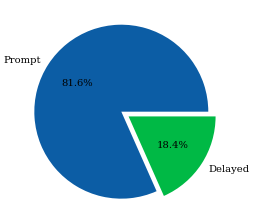

17935306

In [11]:
plt.pie(x=[df_TPC_prompt["Counts"].sum(), df_TPC_delayed["Counts"].sum()], autopct='%1.1f%%', explode=[0, 0.1], labels=["Prompt", "Delayed"])
plt.savefig('./img/prompt-delayed.png', dpi=DPI)
plt.show()
df_TPC_delayed["Counts"].sum()

# Total ratio of counts in TPC to buffer 

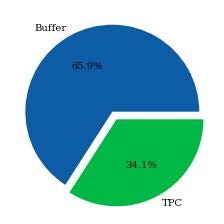

In [12]:
plt.pie(x=[df_buffers["Counts"].sum(), df_TPC_delayed["Counts"].sum() + df_TPC_prompt["Counts"].sum()], explode=[0, 0.1], autopct='%1.1f%%', labels=["Buffer", "TPC"])
plt.savefig('./img/tpc-to-buffer.png', dpi=DPI)
plt.show()

### Add beta decay energy columns

In [13]:
# https://nds.iaea.org/relnsd/vcharthtml/api_v0_notebook.html
# https://nds.iaea.org/relnsd/vcharthtml/api_v0_guide.html#gamma
# https://nds.iaea.org/relnsd/vcharthtml/VChartHTML.html
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
import time

# the service URL
livechart = "https://nds.iaea.org/relnsd/v0/data?"

import urllib.request

def lc_read_csv(url):
    req = urllib.request.Request(url)
    req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
    return pd.read_csv(urllib.request.urlopen(req))

def gamma_dec(iso_sym):
    """Calculates average gamma decay - depreciated"""
    sym = iso_sym.split(" ")[0].lower()
    A = iso_sym.split(" ")[1].split("-")[1]
    df = lc_read_csv(livechart + f"fields=decay_rads&nuclides={str(A)+sym}&rad_types=g")
    if not df.empty:
        try:
            average = (df["energy"] * df["intensity"]/100).sum()
            return average
        except:
            pass
    return None

def g_in_range(iso_sym, min_e, max_e, found_e_range, rad_type):
    "Returns True if gamma found in range else False"
    if rad_type == "bm":
        energy_title = "mean_energy"
    else:
        energy_title = "energy"
    sym = iso_sym.split(" ")[0].lower()
    A = iso_sym.split(" ")[1].split("-")[1]
    df = lc_read_csv(livechart + f"fields=decay_rads&nuclides={str(A)+sym}&rad_types={rad_type}")
    ### IMPORTANT ###
    threshhold_intensity = 0.5
    time.sleep(0.02)
    if not df.empty:
        try:
            df = df[df["intensity_beta"] > threshhold_intensity]
            if df[energy_title].max() > found_e_range[1]:
                found_e_range[1] = df[energy_title].max()
            if df[energy_title].min() < found_e_range[0]:
                found_e_range[0] = df[energy_title].min()
            if df[energy_title].between(min_e,max_e).any():
                return True
        except:
            return np.nan
    return False

Get specific data

In [14]:
A = 41
sym = "ar"
# a bp bm g e x (α, β-, β+ and electron capture, γ, Auger and conversion electron, X-ray)
df = lc_read_csv(livechart + f"fields=decay_rads&nuclides={str(A)+sym}&rad_types=bm")
# df

Add decay columns

In [15]:
min_b_e = 30
max_b_e = 200
found_e_range = [np.inf,0]
rad_type = "bm"
beta_col_name = f"BDecay {min_b_e}-{max_b_e} (keV)"
unstable_TPC_delayed[beta_col_name] = unstable_TPC_delayed.apply(lambda x : g_in_range(x["Iso Symbol"], min_b_e, max_b_e, found_e_range, rad_type), axis = 1)
unstable_TPC_prompt[beta_col_name] = unstable_TPC_prompt.apply(lambda x : g_in_range(x["Iso Symbol"], min_b_e, max_b_e, found_e_range, rad_type), axis = 1)
unstable_buffers[beta_col_name] = unstable_buffers.apply(lambda x : g_in_range(x["Iso Symbol"], min_b_e, max_b_e, found_e_range, rad_type), axis = 1)
print(f"Decay beta energy range (min/max) {found_e_range[0]}-{found_e_range[1]} keV")

Decay beta energy range (min/max) 48.758-10048 keV


# Look for important unstable in buffer
Can't really do this - need another geant4 simulation

# Look for important unstable prompt isotopes in TPC
Isotopes that are produced inside the deadtime, but will live long enough to decay outside this time and emit a detectable signal

In [16]:
unstable_TPC_prompt.sort_values(["Atomic Number", "Mass Number"], ascending=False).head(30)

,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 30-200 (keV)
166,K 19-42,19,42,40,5.013056e-07,False,4.440000e+04,"[[B-, 1.0, 3.526]]",3.526,red,1.3788,4e-07,False
152,K 19-38,19,38,149,1.867363e-06,False,4.580000e+02,"[[EC, 1.0, 5.914]]",5.914,red,5.13603,1.49e-06,False
147,K 19-37,19,37,11,1.378590e-07,False,1.230000e+00,"[[EC, 1.0, 6.147]]",6.147,red,0.37917,1.1e-07,False
141,K 19-36,19,36,3,3.759792e-08,False,3.420000e-01,"[[EC, 1.0, 12.805], [EP, 0.0005, 4.298], [EA, ...",12.805,red,0.10341,3e-08,False
124,K 19-33,19,33,1,1.253264e-08,False,2.500000e-08,"[[P, None, 1.674]]",1.674,red,0.03447,1e-08,False
162,Ar 18-41,18,41,95572,1.197769e-03,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,3294.37,0.00095572,False
146,Ar 18-37,18,37,92179,1.155246e-03,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,3177.41,0.00092179,False
135,Ar 18-35,18,35,529,6.629766e-06,False,1.780000e+00,"[[EC, 1.0, 5.966]]",5.966,red,18.2346,5.29e-06,False
130,Ar 18-34,18,34,36,4.511750e-07,False,8.450000e-01,"[[EC, 1.0, 6.063]]",6.063,red,1.24092,3.6e-07,False
158,Cl 17-40,17,40,20261,2.539238e-04,False,8.100000e+01,"[[B-, 1.0, 7.482]]",7.482,red,698.397,0.00020261,False


In [24]:
# Filter with halflife greater than deadtime (lasts long enough)
important_TPC_prompt = unstable_TPC_prompt[unstable_TPC_prompt["Half Life (s)"] > 0.000020].sort_values("Production (/yr)", ascending=False).reset_index(drop=True)
# Filter with beta energy ranges
important_TPC_prompt = important_TPC_prompt[pd.isnull(important_TPC_prompt[beta_col_name]) | (important_TPC_prompt[beta_col_name] == True)]

print(f"Number of isotopes in range: {len(important_TPC_prompt)}")
print(f"Total Production (/yr): {important_TPC_prompt['Production (/yr)'].sum()}")
important_TPC_prompt

Number of isotopes in range: 7
Total Production (/yr): 2634.4731600000005


,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 30-200 (keV)
4,S 16-35,16,35,53426,6.695688e-04,False,7550000.000,"[[B-, 1.0, 0.167]]",0.167,red,1841.59,0.00053426,True
7,P 15-33,15,33,15199,1.904836e-04,False,2190000.000,"[[B-, 1.0, 0.249]]",0.249,red,523.91,0.00015199,True
9,S 16-38,16,38,7085,8.879375e-05,False,10200.000,"[[B-, 1.0, 2.937]]",2.937,red,244.22,7.085e-05,True
25,Mg 12-28,12,28,465,5.827677e-06,False,75300.000,"[[B-, 1.0, 1.832]]",1.832,red,16.0285,4.65e-06,True
34,Si 14-34,14,34,243,3.045431e-06,False,2.770,"[[B-, 1.0, 4.601]]",4.601,red,8.37621,2.43e-06,NaN
81,F 9-23,9,23,9,1.127938e-07,False,2.230,"[[B-, 1.0, 8.484]]",8.484,red,0.31023,9e-08,NaN
102,Al 13-34,13,34,1,1.253264e-08,False,0.042,"[[B-, 1.0, 17.024], [BN, 0.27, 9.489]]",17.024,red,0.03447,1e-08,NaN


# Look for important unstable delayed isotopes in TPC

## Any isotopes that beta decay

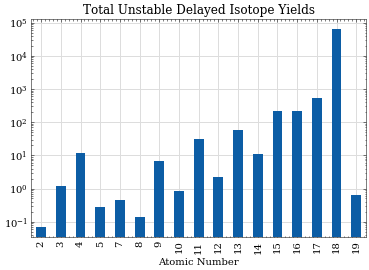

,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 30-200 (keV)
0,K 19-42,19,42,10,5.575595e-07,False,4.440000e+04,"[[B-, 1.0, 3.526]]",3.526,red,0.3447,1e-07,False
1,K 19-38,19,38,8,4.460476e-07,False,4.580000e+02,"[[EC, 1.0, 5.914]]",5.914,red,0.27576,8e-08,False
2,Ar 18-41,18,41,1788656,9.972821e-02,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,61655,0.0178866,False
3,Ar 18-37,18,37,47785,2.664298e-03,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,1647.15,0.00047785,False
4,Cl 17-39,17,39,591,3.295177e-05,False,3.370000e+03,"[[B-, 1.0, 3.442]]",3.442,red,20.3718,5.91e-06,False
5,Cl 17-38,17,38,14978,8.351126e-04,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,516.292,0.00014978,False
6,Cl 17-34,17,34,133,7.415541e-06,False,1.530000e+00,"[[EC, 1.0, 5.492]]",5.492,red,4.58451,1.33e-06,False
7,S 16-39,16,39,1,5.575595e-08,False,1.150000e+01,"[[B-, 1.0, 6.638]]",6.638,red,0.03447,1e-08,False
8,S 16-38,16,38,187,1.042636e-05,False,1.020000e+04,"[[B-, 1.0, 2.937]]",2.937,red,6.44589,1.87e-06,True
9,S 16-37,16,37,1011,5.636926e-05,False,3.030000e+02,"[[B-, 1.0, 4.865]]",4.865,red,34.8492,1.011e-05,False


In [18]:
# All unstable that beta decay with decays per year > 1
unstable_TPC_delayed_beta = unstable_TPC_delayed.sort_values(["Atomic Number", "Mass Number"], ascending=False).reset_index(drop=True)
unstable_TPC_delayed_grouped = unstable_TPC_delayed_beta.groupby(['Atomic Number'])["Production (/yr)"].sum()
ax = unstable_TPC_delayed_grouped.plot.bar(x="Atomic Number", log=True)
ax.grid(which='major', color='#dddddd', lw=1)
ax.set_axisbelow(True)
plt.title("Total Unstable Delayed Isotope Yields")
plt.show()
unstable_TPC_delayed_beta.head(70)

## Filter with high probability for beta emission in range

In [19]:
# Filter with beta energy ranges
important_TPC_delayed = unstable_TPC_delayed[pd.isnull(unstable_TPC_delayed[beta_col_name]) | (unstable_TPC_delayed[beta_col_name] == True)].sort_values("Counts", ascending=False).reset_index(drop=True)

print(f"Number of isotopes in range: {len(important_TPC_delayed)}")
print(f"Total Production (yr): {important_TPC_delayed['Production (/yr)'].sum()}\n")

print(f"Beta decays: {len(important_TPC_delayed[important_TPC_delayed[beta_col_name] == True])}")
print(f"Beta decay productions (/yr): {important_TPC_delayed.loc[important_TPC_delayed[beta_col_name] == True, 'Production (/yr)'].sum()}\n")

Number of isotopes in range: 5
Total Production (yr): 206.06166

Beta decays: 4
Beta decay productions (/yr): 205.95825



In [20]:
file_dir = f"./assets/{physic_model}/important_iso.csv"
important_TPC_delayed.to_csv(file_dir)
important_TPC_delayed

,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 30-200 (keV)
0,S 16-35,16,35,5204,2.901540e-04,False,7550000.00,"[[B-, 1.0, 0.167]]",0.167,red,179.382,5.204e-05,True
1,P 15-33,15,33,576,3.211543e-05,False,2190000.00,"[[B-, 1.0, 0.249]]",0.249,red,19.8547,5.76e-06,True
2,S 16-38,16,38,187,1.042636e-05,False,10200.00,"[[B-, 1.0, 2.937]]",2.937,red,6.44589,1.87e-06,True
3,Mg 12-28,12,28,8,4.460476e-07,False,75300.00,"[[B-, 1.0, 1.832]]",1.832,red,0.27576,8e-08,True
4,Si 14-34,14,34,3,1.672678e-07,False,2.77,"[[B-, 1.0, 4.601]]",4.601,red,0.10341,3e-08,NaN


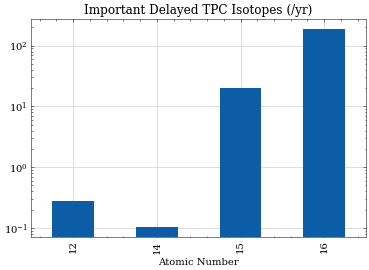

In [21]:
important_TPC_delayed_groups = important_TPC_delayed.groupby(['Atomic Number'])["Production (/yr)"].sum()
ax = important_TPC_delayed_groups.plot.bar(x="Atomic Number", log=True)
ax.grid(which='major', color='#dddddd', lw=1)
ax.set_axisbelow(True)
plt.title("Important Delayed TPC Isotopes (/yr)")
plt.show()

# Combine df and convert to latex

In [22]:
important_combined = pd.concat([important_TPC_prompt.sort_values("Counts", ascending=False), important_long_lived, important_TPC_delayed.sort_values("Counts", ascending=False), unstable_TPC_delayed_beta.sort_values("Counts", ascending=False)]).reset_index(drop=True)

def convert_iso(symbol):
    if symbol:
        name, nums = symbol.split(" ")
        num = nums.split("-")[1]
        return "$^{"+ str(num) + "}$" + str(name)

def convert_decays(decays):
    output = ""
    for decay in decays:
        if decay:
            if decay[0] == "B-":
                output = output + "$\ beta$-, "
            elif decay[0] == "B+":
                output = output + "$\ beta$+, "
            elif decay[0] == "A":
                output = output + "$\ alpha$, "
            elif decay[0] == "BA":
                output = output + "$\ beta$-$\ alpha$, "
            elif decay[0] == "BN":
                output = output + "$\ beta$-N, "
            elif decay[0] == "B3A":
                output = output + "$\ beta$-3$\ alpha$, "
            else:
                output = output + str(decay[0]) + ", "
    return output[:-2]
important_combined["Iso Symbol"] = important_combined.apply(lambda x : convert_iso(x["Iso Symbol"]), axis = 1)
important_combined["Decay Modes (m, b, q MeV)"] = important_combined.apply(lambda x : convert_decays(x["Decay Modes (m, b, q MeV)"]), axis = 1)

a = len(important_TPC_prompt)
b = len(important_long_lived)
c = len(important_TPC_delayed)
d = len(unstable_TPC_delayed_beta)

print("\nSums:")
print(f"Sum Total: {round(important_combined['Production (/yr)'].sum(), 3)}, {important_combined['Yield per Muon (/yr)'].sum()}")
print(f"Sum TPC: {round(important_combined.loc[0 : a, 'Production (/yr)'].sum(), 3)}, {important_combined.loc[0 : a, 'Yield per Muon (/yr)'].sum()}")
print(f"Sum Long lived: {round(important_combined.loc[a : a + b, 'Production (/yr)'].sum(), 3)}, {important_combined.loc[a : a + b, 'Yield per Muon (/yr)'].sum()}")
print(f"Sum Delayed: {round(important_combined.loc[a + b : a + b + c, 'Production (/yr)'].sum(), 3)}, {important_combined.loc[a + b : a + b + c, 'Yield per Muon (/yr)'].sum()}")
print(f"Sum Delayed: {round(important_combined.loc[a + b + c : a + b + c + d, 'Production (/yr)'].sum(), 3)}, {important_combined.loc[a + b + c : a + b + c + d, 'Yield per Muon (/yr)'].sum()}")

important_combined = important_combined[["Iso Symbol", "Production (/yr)", "Yield per Muon (/yr)", "Half Life (s)", "Decay Modes (m, b, q MeV)"]]
important_combined['Production (/yr)'] = important_combined['Production (/yr)'].map('{:.3f}'.format)
important_combined['Production (/yr)'] = important_combined['Production (/yr)'].map(float)
important_combined["Yield per Muon (/yr)"] = important_combined["Yield per Muon (/yr)"].map("{:.2E}".format)
important_combined["Yield per Muon (/yr)"] = important_combined["Yield per Muon (/yr)"].apply(lambda x: ("\num" + "{" + f"{x}" + "}"))
important_combined["Half Life (s)"] = important_combined["Half Life (s)"].map("{:.3E}".format)
important_combined["Half Life (s)"] = important_combined["Half Life (s)"].apply(lambda x: ("\num" + "{" + f"{x}" + "}"))

print("Table Splitting (exclusive)")
print(f"Total: {len(important_combined)}")
print(f"TPC Prompt: 0-{a}")
print(f"Long lived: {a}-{a + b}")
print(f"TPC Delayed: {a + b}-{a + b + c}")
print(f"TPC Delayed Beta: {a + b + c}-{a + b + c + d}")
print("Rest is all unstable in TPC")


Sums:
Sum Total: 234162.293, 0.06793219999999997
Sum TPC: 75.455, 2.189e-05
Sum Long lived: 169733.072, 0.04924081000000002
Sum Delayed: 61861.034, 0.017946339999999998
Sum Delayed: 64402.542, 0.01868365000000001
Table Splitting (exclusive)
Total: 82
TPC Prompt: 0-0
Long lived: 0-31
TPC Delayed: 31-36
TPC Delayed Beta: 36-82
Rest is all unstable in TPC


C:\Users\TSBus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [23]:
print("\n", important_combined.to_latex(index=True,escape=False))


 \begin{tabular}{llrlll}
\toprule
{} & Iso Symbol &  Production (/yr) & Yield per Muon (/yr) &    Half Life (s) &                  Decay Modes (m, b, q MeV) \\
\midrule
0  &  $^{40}$Ca &            75.455 &       \num{2.19E-05} &  \num{9.470E+28} &                                        2EC \\
1  &  $^{41}$Ca &             0.310 &       \num{9.00E-08} &  \num{3.220E+12} &                                         EC \\
2  &  $^{40}$Ca &             0.034 &       \num{1.00E-08} &  \num{9.470E+28} &                                        2EC \\
3  &  $^{40}$Ca &           167.111 &       \num{4.85E-05} &  \num{9.470E+28} &                                        2EC \\
4  &  $^{41}$Ca &             0.172 &       \num{5.00E-08} &  \num{3.220E+12} &                                         EC \\
5  &   $^{40}$K &           186.621 &       \num{5.41E-05} &  \num{3.940E+16} &                              $\ beta$-, EC \\
6  &   $^{40}$K &            83.934 &       \num{2.43E-05} &  \num{3.940E+